In [14]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import xgboost as xgb
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

sns.set_context("paper", font_scale=1.4)
sns.set_style("darkgrid")

# cross-validation settings
N_SPLITS = 5
N_REPEATS = 5
SEED = 42

### Load experiments results

In [135]:
lr_res = joblib.load(os.path.join('Experiment results', 'lr_res.pth'))
lgbm_res = joblib.load(os.path.join('Experiment results', 'lgbm_res.pth'))

lr_res

{'val_scores': array([0.4758, 0.4954, 0.4833, 0.4628, 0.5045, 0.4746, 0.4874, 0.4804,
        0.4815, 0.4930, 0.4964, 0.4531, 0.5053, 0.4716, 0.4890, 0.4805,
        0.4628, 0.5173, 0.4740, 0.4850, 0.4642, 0.5008, 0.4757, 0.4932,
        0.4801]),
 'fpr': array([0.0000, 0.0000, 0.0000, ..., 0.9982, 0.9982, 1.0000]),
 'tpr': array([0.0000, 0.0001, 0.0018, ..., 0.9996, 1.0000, 1.0000]),
 'test_auc': 0.7400610702142025,
 'n_sample': [50, 100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 20000],
 'gini_sample': [0.1981353633493732,
  0.2982058571122077,
  0.40825251859632905,
  0.45221394764143086,
  0.473910980494868,
  0.4745437061329574,
  0.4775012631293474,
  0.47816057485388086,
  0.4795984293543829,
  0.48012214042840506]}

### Boxplot

In [136]:
lr = pd.DataFrame(lr_res['val_scores'], columns=['GINI'])
lr['model'] = 'Logistc regression'

lgbm = pd.DataFrame(lgbm_res['val_scores'], columns=['GINI'])
lgbm['model'] = 'LightGBM'

res = pd.concat([lgbm, lr], axis=0)

<AxesSubplot:xlabel='GINI', ylabel='model'>

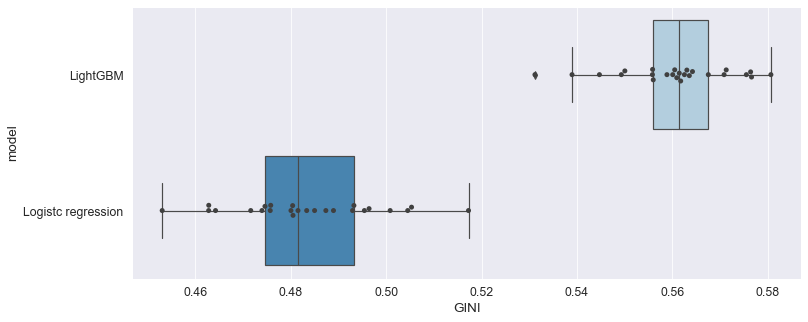

In [137]:
fig, ax = plt.subplots(figsize=(12,5))

sns.boxplot(x='GINI', y='model', data=res, palette="Blues")
sns.swarmplot(x='GINI', y='model', data=res, color=".25")

### RoC

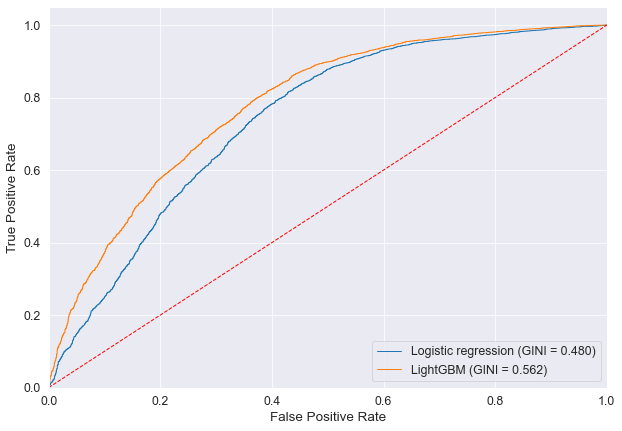

In [138]:
fig, ax = plt.subplots(figsize=(10,7))

fpr, tpr = lr_res['fpr'], lr_res['tpr']
ax.plot(fpr, tpr, lw=1, label='Logistic regression (GINI = %0.3f)' % (lr_res['test_auc'] * 2 - 1))

fpr, tpr = lgbm_res['fpr'], lgbm_res['tpr']
ax.plot(fpr, tpr, lw=1, label='LightGBM (GINI = %0.3f)' % (lgbm_res['test_auc'] * 2 - 1))


ax.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")

### Performance vs sample size

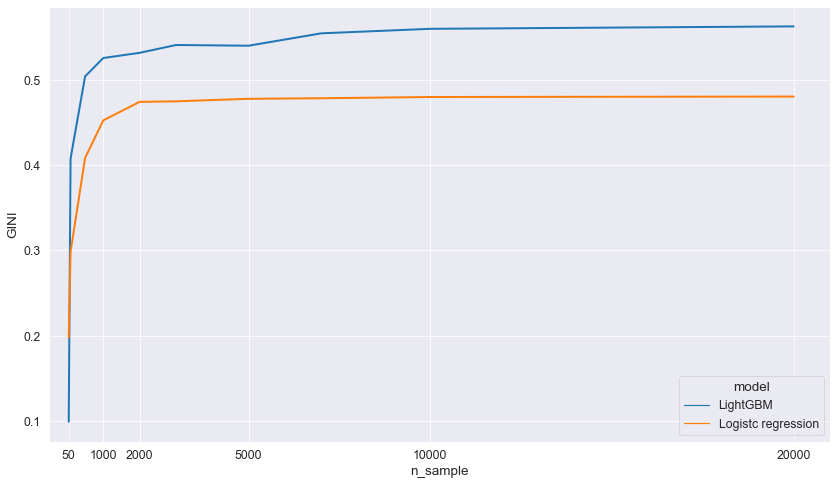

In [139]:
lr = pd.DataFrame(lr_res['gini_sample'], columns=['GINI'])
lr['n_sample'] = lr_res['n_sample']
lr['model'] = 'Logistc regression'

lgbm = pd.DataFrame(lgbm_res['gini_sample'], columns=['GINI'])
lgbm['n_sample'] = lgbm_res['n_sample']
lgbm['model'] = 'LightGBM'

res = pd.concat([lgbm, lr], axis=0)

fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(data=res, x='n_sample', y='GINI', hue='model', lw=2)
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])